# Model Evaluation

In [1]:
# Import library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image
from tqdm import tqdm

# Open file
import os
import PIL
import cv2
from os import listdir
from random import shuffle

# Model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report,f1_score

In [2]:
def create_label(word_label):
    ''' 
        Input : subdirectories path have nane file with class label 
        Return : number of classes label of each class 
    '''
    if word_label == "Coccidiosis":
        return 0
    elif word_label == "Healthy poultry":
        return 1
    elif word_label == "Newcastle diseases":
        return 2
    elif word_label == "Salmonella":
        return 3

In [3]:
def created_dataset(DIR):
    '''
        Input : directories file have image file to want label   
        Return : dataframe of arrary image (RGB-3D shape) follow by img_height and img_width and label of each classes image 
    '''
    created_dataset = []
    for labels_c in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, labels_c)
        for file in listdir(path):
            img_data = cv2.imread(path+ "/" + file) 
            img_data = cv2.resize(img_data, (img_height , img_width))
            img_data = cv2.cvtColor(img_data, cv2.COLOR_RGB2BGR)
            created_dataset.append([np.array(img_data), create_label(labels_c)])
    shuffle(created_dataset)
    return pd.DataFrame(created_dataset, columns=["picture","labels"])

In [4]:
def load_model(model_path):
    '''
        Input : subdirectories of model 
        Return : model of keras api with not complie 
    '''
    model = tf.keras.models.load_model(model_path, compile = False)
    return model

In [5]:
# Create function plot graph
def plot_graph(history_model, finetune=False, initial_epochs=0):
    ''' 
        Input : Model_values of keras.callbacks.History
        Return : Graph of Loss funtion and Mean squared error between training dataset and testing dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history_model['loss'], label='Training Loss');
    plt.plot(history_model['val_loss'], label='Testing Loss');
    if finetune==True:
        plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_model['accuracy'], label='Training Accuracy')
    plt.plot(history_model['val_accuracy'], label='Validation Accuracy')
    if finetune==True:
        plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy');

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def get_metric(model, X, y_actual, name_model=None, figsize=(12, 10)):
    '''
    Input : model = model of keras api 
            X = array of image follow by reshape and rescale fit for model input 
            y_actual = label of each image(X)
            name_model = str name of model want to show 
    Return : accuracy, precision, recall, F1 score, per-class accuracy, and confusion matrix
    '''
    prods_softmax = model.predict(X)
    y_preds = np.argmax(prods_softmax, axis=1)
    
    print(f"Model : {name_model}")
    print("-" * 50)
    
    labels = ['Coccidiosis', 'Salmonella', 'Newcastle', 'Healthy']
    
    # Compute metrics
    accuracy = accuracy_score(y_actual, y_preds)
    precision = precision_score(y_actual, y_preds, average='macro')
    recall = recall_score(y_actual, y_preds, average='macro')
    f1 = f1_score(y_actual, y_preds, average='macro')
    
    # Per-class accuracy
    per_class_accuracy = []
    for i in range(len(labels)):
        class_accuracy = accuracy_score(y_actual[y_actual == i], y_preds[y_actual == i])
        per_class_accuracy.append(class_accuracy)

    
    # Confusion matrix
    cm = confusion_matrix(y_actual, y_preds)
    
    # Print metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\nPer-class Accuracy:")
    for label, acc in zip(labels, per_class_accuracy):
        print(f"{label}: {acc:.2f}")

        # Display confusion matrix figure
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    # # Print confusion matrix
    # print("\nConfusion Matrix:")
    # print(cm)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_actual, y_preds, target_names=labels))


In [7]:
def get_values_model(X , y_actual, history_model, model, name_model="", model_path=None):
 
    ''' Show the overall metric model
        Parameter : X = array of image follow by reshape and rescale fit for model input
                    y_actual : label of each image(X)
                    history_model : model_values of keras.callbacks.History
                    model : model of keras api 
                    name_model : str name of model want to show
                    model_path : subdirectories of model 
        Return : Add value of model to set of 
                model_name, loss, val_loss, accuracy, val_accuracy, F1_score, size_mb, number_params, input_size   
    '''
    
    # Predict model 
    prods_softmax = model.predict(X)
    y_preds = np.array([np.where(v == v.max())[0][0] for v in prods_softmax])
    
    # Add values
    model_name.append(name_model)
    loss.append(round(history_model.iloc[-1]["loss"],2))
    val_loss.append(round(history_model.iloc[-1]["val_loss"],2))
    accuracy.append(round(history_model.iloc[-1]["accuracy"],2))
    val_accuracy.append(round(history_model.iloc[-1]["val_accuracy"],2))
    F1_score.append(round(f1_score(y_actual, y_preds, average = 'macro'),2))
    size_mb.append(round(os.stat(model_path).st_size/1_048_576 , 2))
    number_params.append(f'{model.count_params():,}')
    input_size.append(model.input_shape)

## 01- Open dataset

In [8]:
# Define the paths
original_dataset_path = r'C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\poultry_data'
train_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\Train"
validation_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\Validate"
test_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\Test"

## 02- Preprocessing image dataset

In [9]:
# Create dataframe of validation and testing dataset 
# for model CNN and mobileNetV2
# Using input image size 128x128
img_height=128
img_width=128
df_valid = created_dataset(DIR=validation_path)
df_test = created_dataset(DIR=test_path)

100%|███████████████████████████████████████████████████████████| 4/4 [04:39<00:00, 69.88s/it]


In [10]:
# Recheck
df_valid.head()

,picture,labels
0,"[[[127, 103, 94], [114, 98, 79], [132, 111, 91...",0
1,"[[[130, 82, 13], [142, 97, 30], [131, 94, 20],...",0
2,"[[[78, 77, 71], [65, 68, 60], [74, 70, 53], [1...",3
3,"[[[162, 139, 110], [128, 110, 86], [132, 117, ...",3
4,"[[[39, 21, 6], [27, 16, 0], [73, 53, 33], [106...",0


In [11]:
# Recheck
df_test.head()

,picture,labels
0,"[[[56, 89, 122], [35, 80, 129], [62, 129, 157]...",3
1,"[[[255, 255, 253], [255, 255, 250], [252, 245,...",0
2,"[[[156, 144, 138], [169, 160, 153], [58, 40, 3...",1
3,"[[[129, 128, 124], [132, 131, 127], [136, 137,...",3
4,"[[[109, 107, 106], [116, 116, 106], [113, 111,...",1


In [12]:
# Define X and y for
X_valid = np.array([i for i in df_valid["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_valid = df_valid["labels"]
X_test = np.array([i for i in df_test["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_test = df_test["labels"]

In [13]:
# Check shape before prediction with model
X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((1738, 128, 128, 3), (1738,), (1741, 128, 128, 3), (1741,))

In [14]:
# Check class in y_valid
pd.Series(y_valid).value_counts(normalize=True).mul(100).sort_index(ascending=True)

labels
0    24.223245
1    23.647871
2    25.949367
3    26.179517
Name: proportion, dtype: float64

In [15]:
# Check class in y_test
pd.Series(y_test).value_counts(normalize=True).mul(100).sort_index(ascending=True)

labels
0    24.181505
1    23.664561
2    25.962091
3    26.191844
Name: proportion, dtype: float64

In [16]:
# Define labels dictionary of each class
labels_dict = {'Coccidiosis':0, 'Healthy poultry':1, 'Newcastle diseases':2, 'Salmonella':3}

## 03- SoloConvLayer

In [17]:
# path of model 
cnn_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\cnn\cnn_model.h5"

# load model 
cnn_model = load_model(model_path=cnn_path)

In [18]:
# check model summary
# 2,102,564 parameters
# Get file size in bytes for a given model
print(f"Size of model(MB): {(os.stat(cnn_path).st_size/1_048_576)}") # convert Bytes to MB

cnn_model.summary()

Size of model(MB): 24.10467529296875
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)     

55/55 [==============================] - 2s 41ms/step
Model : SoloConvLayer Model
--------------------------------------------------
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.97

Per-class Accuracy:
Coccidiosis: 0.97
Salmonella: 1.00
Newcastle: 0.94
Healthy: 0.97


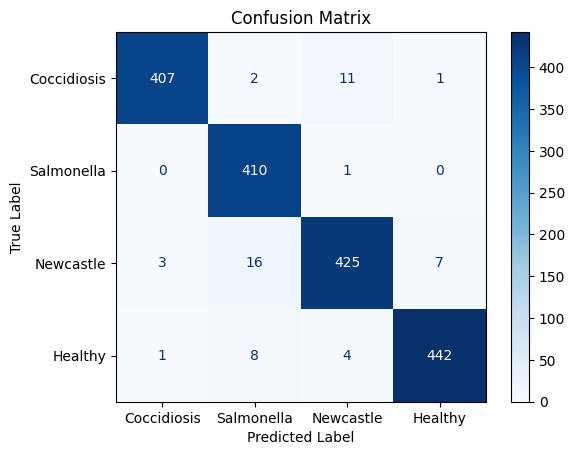


Classification Report:
              precision    recall  f1-score   support

 Coccidiosis       0.99      0.97      0.98       421
  Salmonella       0.94      1.00      0.97       411
   Newcastle       0.96      0.94      0.95       451
     Healthy       0.98      0.97      0.98       455

    accuracy                           0.97      1738
   macro avg       0.97      0.97      0.97      1738
weighted avg       0.97      0.97      0.97      1738



In [33]:
get_metric(model=cnn_model,
           X=X_valid,
           name_model="SoloConvLayer Model",
           y_actual=y_valid,
           figsize=(12, 10))

        loss  accuracy  val_loss  val_accuracy
20  0.121941  0.954189  0.101824      0.968930
21  0.143735  0.946278  0.161151      0.962601
22  0.138657  0.946494  0.102363      0.971807
23  0.118779  0.954764  0.181306      0.957422
24  0.114583  0.958360  0.103628      0.967204


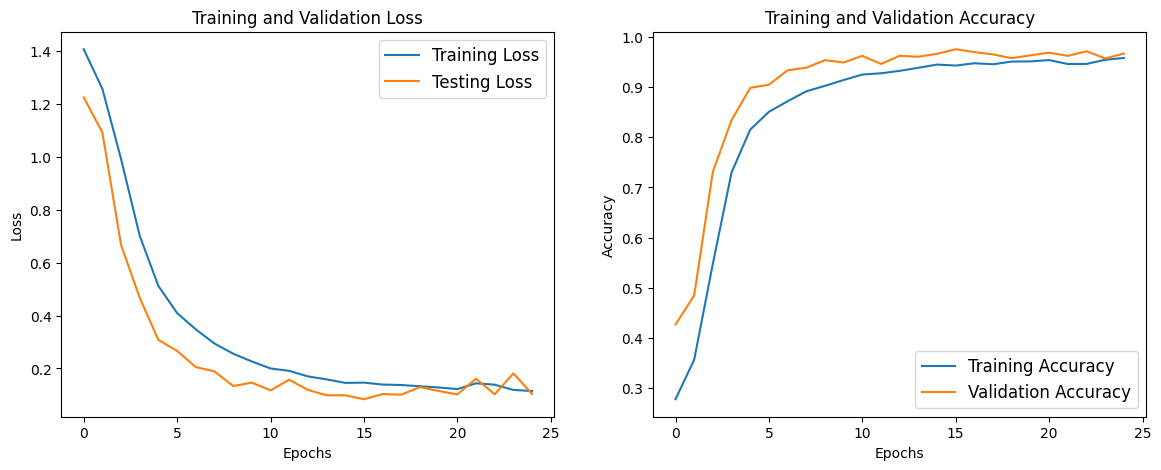

In [20]:
# See history of model  training
histort_cnn_model = pd.read_csv("C:\\Users\\HP\\Desktop\\Data\\poultry_disease_detection_third_iteration\\models\\cnn\\history_cnn_model16.csv")
plot_graph(histort_cnn_model)
print(histort_cnn_model.tail())

## 04- Transfer Learning and Fine Tuning MobileNetV2 Model

In [21]:
# path of model 
mobnv2_tf_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\mobilenetv2\mobilenetv2.h5"
mobnv2_ft_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\mobilenetv2\mobilenetv2_ft.h5"

# load model 
mobnv2_tf_model = load_model(model_path=mobnv2_tf_path)
mobnv2_ft_model = load_model(model_path=mobnv2_ft_path)

In [22]:
# check model summary
# Total params: 2,263,108 parameters (equal params between transfer learning and fine tuning )
# Get file size in bytes for a given model
print(f"Size of MobileNetV2 transfer learning model(MB): {(os.stat(mobnv2_tf_path).st_size/1_048_576)}") # convert Bytes to MB
print(f"Size of MobileNetV2 fine tuning model(MB): {(os.stat(mobnv2_ft_path).st_size/1_048_576)}")

Size of MobileNetV2 transfer learning model(MB): 9.150642395019531
Size of MobileNetV2 fine tuning model(MB): 23.466957092285156


In [23]:
# check model summary
# Trainable params: 5,124
mobnv2_tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [24]:
# check model summary
# Trainable params: 1,866,564
mobnv2_ft_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

55/55 [==============================] - 12s 216ms/step
Model : MobileNetV2 Transfer Learning Model
--------------------------------------------------
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.97

Per-class Accuracy:
Coccidiosis: 0.97
Salmonella: 0.96
Newcastle: 0.98
Healthy: 0.96


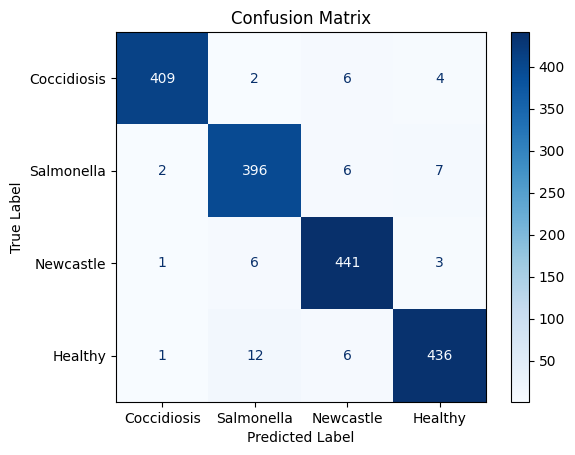


Classification Report:
              precision    recall  f1-score   support

 Coccidiosis       0.99      0.97      0.98       421
  Salmonella       0.95      0.96      0.96       411
   Newcastle       0.96      0.98      0.97       451
     Healthy       0.97      0.96      0.96       455

    accuracy                           0.97      1738
   macro avg       0.97      0.97      0.97      1738
weighted avg       0.97      0.97      0.97      1738



In [34]:
# See confusion_matrix of model 
get_metric(model=mobnv2_tf_model,
          X=X_valid,
          name_model="MobileNetV2 Transfer Learning Model",
          y_actual=y_valid)

55/55 [==============================] - 12s 221ms/step
Model : MobileNetV2 Fine Tuning Model
--------------------------------------------------
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98

Per-class Accuracy:
Coccidiosis: 1.00
Salmonella: 1.00
Newcastle: 0.95
Healthy: 0.98


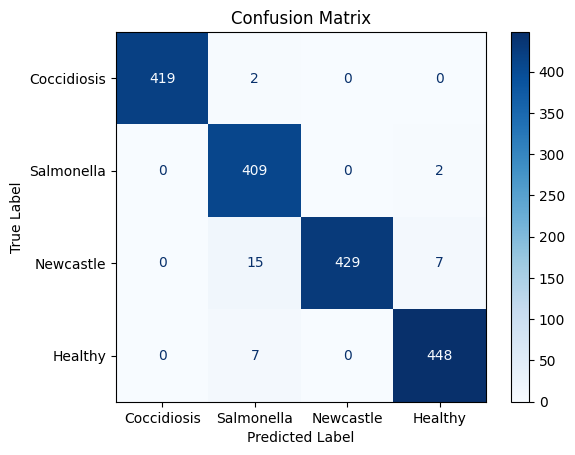


Classification Report:
              precision    recall  f1-score   support

 Coccidiosis       1.00      1.00      1.00       421
  Salmonella       0.94      1.00      0.97       411
   Newcastle       1.00      0.95      0.97       451
     Healthy       0.98      0.98      0.98       455

    accuracy                           0.98      1738
   macro avg       0.98      0.98      0.98      1738
weighted avg       0.98      0.98      0.98      1738



In [35]:
# See confusion_matrix of model 
get_metric(model=mobnv2_ft_model,
          X=X_valid,
          name_model="MobileNetV2 Fine Tuning Model",
          y_actual=y_valid)

In [27]:
# See history of model training both transfer learing or fine tuning
histort_mobnv2_tf_model = pd.read_csv("C:\\Users\\HP\\Desktop\\Data\\poultry_disease_detection_third_iteration\\models\\mobilenetv2\\history_mobilenetv2_tl.csv")
# "C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\mobilenetv2\history_mobilenetv2_tl.csv"
histort_mobnv2_ft_model = pd.read_csv("C:\\Users\\HP\\Desktop\\Data\\poultry_disease_detection_third_iteration\\models\\mobilenetv2\\history_mobilenetv2_ft.csv")
histort_mobnv2_model = pd.concat([histort_mobnv2_tf_model, histort_mobnv2_ft_model], ignore_index=True)
histort_mobnv2_model.tail()

,loss,accuracy,val_loss,val_accuracy
45,0.015556,0.994678,0.278404,0.963176
46,0.015256,0.994678,1.052580,0.912543
47,0.008435,0.997699,0.202429,0.972382
48,0.008150,0.996979,0.538638,0.948216
49,0.008878,0.997339,0.247596,0.978136


In [28]:
# See only history of model training transfer learing
histort_mobnv2_tf_model.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.044692,0.987127,0.104995,0.962601
21,0.042496,0.987990,0.104871,0.960875
22,0.042511,0.987271,0.105731,0.959724
23,0.040704,0.988493,0.099449,0.963176
24,0.038126,0.989860,0.096292,0.966053


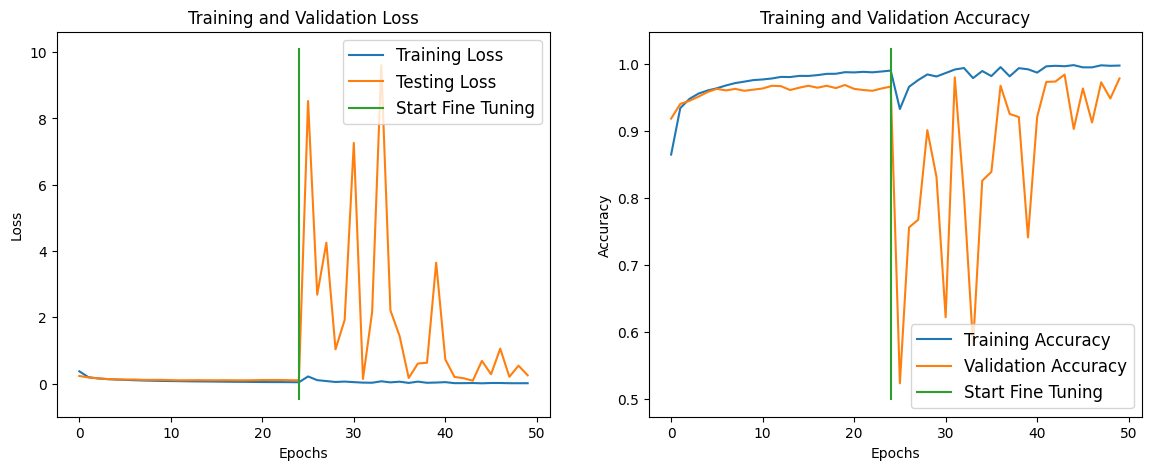

In [29]:
# Show graph
plot_graph(histort_mobnv2_model,finetune=True, initial_epochs=25)

## 05- 224x224 Models

In [30]:
# Create dataframe of validation and testing dataset 
# for model VGG16 
# Using input image size 224x224
img_height= 224
img_width= 224
df_valid_224 = created_dataset(DIR=validation_path)
df_test_224 = created_dataset(DIR=test_path)

100%|███████████████████████████████████████████████████████████| 4/4 [04:40<00:00, 70.11s/it]


In [31]:
# Define X and y and reshape
X_valid_224 = np.array([i for i in df_valid_224["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_valid_224 = df_valid_224["labels"]
X_test_224 = np.array([i for i in df_test_224["picture"]]).reshape(-1, img_height,img_width, 3)/ 255.0
y_test_224 = df_test_224["labels"]

In [32]:
# Check shape before prediction with model
X_valid_224.shape, y_valid_224.shape, X_test_224.shape, y_test_224.shape

((1738, 224, 224, 3), (1738,), (1741, 224, 224, 3), (1741,))

In [36]:
# path of model 
cnn2_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\cnn-copy-2\cnn_model.h5"

# load model 
cnn2_model = load_model(model_path=cnn2_path)

55/55 [==============================] - 6s 98ms/step
Model : FiveConvLayer model
--------------------------------------------------
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 Score: 0.97

Per-class Accuracy:
Coccidiosis: 0.98
Salmonella: 0.95
Newcastle: 0.99
Healthy: 0.97


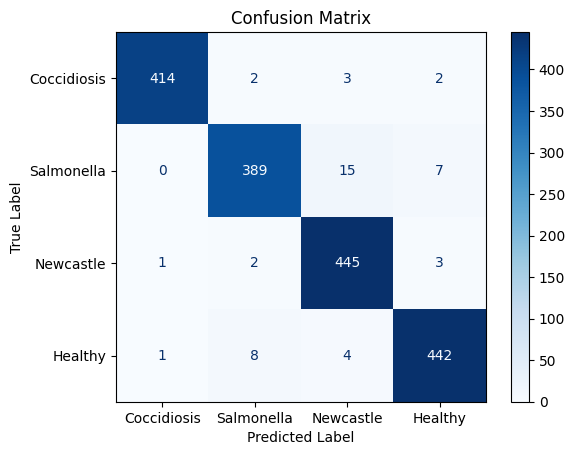


Classification Report:
              precision    recall  f1-score   support

 Coccidiosis       1.00      0.98      0.99       421
  Salmonella       0.97      0.95      0.96       411
   Newcastle       0.95      0.99      0.97       451
     Healthy       0.97      0.97      0.97       455

    accuracy                           0.97      1738
   macro avg       0.97      0.97      0.97      1738
weighted avg       0.97      0.97      0.97      1738



In [37]:
get_metric(model=cnn2_model,
           X=X_valid_224,
           name_model="FiveConvLayer model",
           y_actual=y_valid_224,
           figsize=(12, 10))

        loss  accuracy  val_loss  val_accuracy
20  0.058494  0.981517  0.064703      0.981588
21  0.059350  0.982021  0.082133      0.974684
22  0.053476  0.982740  0.090048      0.967779
23  0.059771  0.980511  0.065452      0.979862
24  0.037722  0.987055  0.092744      0.976410


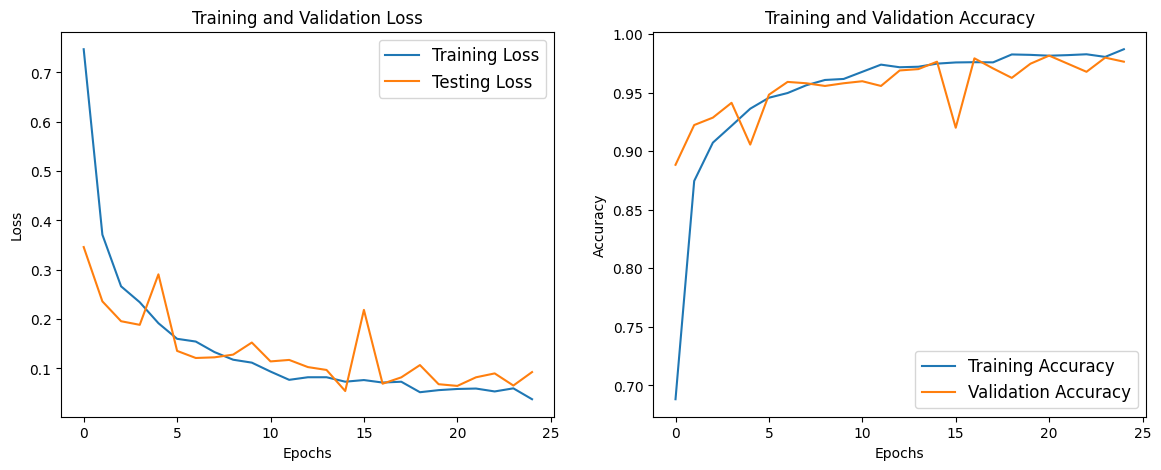

In [48]:
# See history of model  training
histort_cnn_model_2 = pd.read_csv("C:\\Users\\HP\\Desktop\\Data\\poultry_disease_detection_third_iteration\\models\\cnn-copy-2\\history_cnn_model16.csv")
plot_graph(histort_cnn_model_2)
print(histort_cnn_model_2.tail())

In [38]:
# path of model 
cnn1_path = r"C:\Users\HP\Desktop\Data\poultry_disease_detection_third_iteration\models\cnn-copy-1\cnn_model.h5"

# load model 
cnn1_model = load_model(model_path=cnn1_path)

        loss  accuracy  val_loss  val_accuracy
20  0.066812  0.976699  0.089869      0.971807
21  0.083726  0.973031  0.087193      0.971231
22  0.073996  0.975908  0.097121      0.975834
23  0.071834  0.976555  0.082633      0.972957
24  0.083981  0.974038  0.075565      0.979287


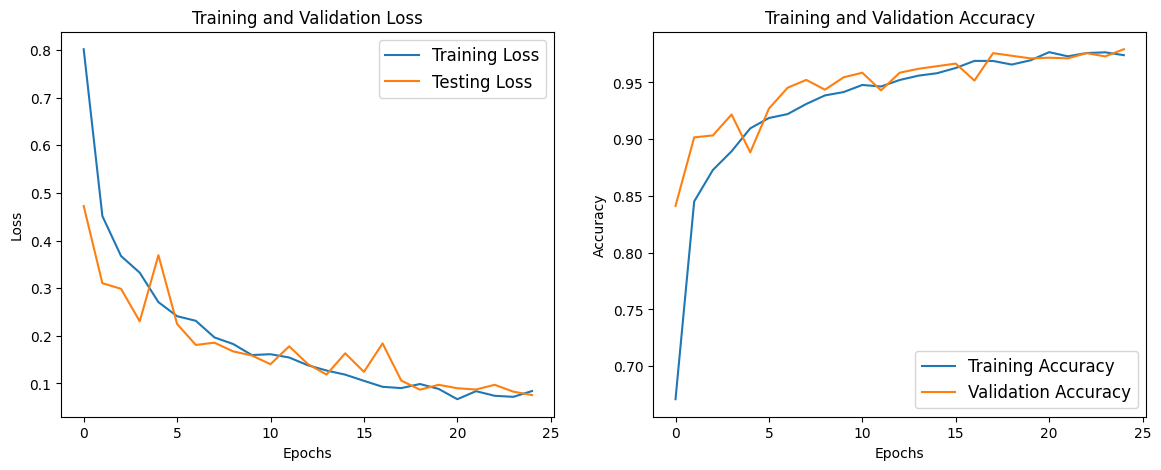

In [49]:
# See history of model  training
histort_cnn_model_1 = pd.read_csv("C:\\Users\\HP\\Desktop\\Data\\poultry_disease_detection_third_iteration\\models\\cnn-copy-1\\history_cnn_model16.csv")
plot_graph(histort_cnn_model_1)
print(histort_cnn_model_1.tail())

55/55 [==============================] - 5s 90ms/step
Model : TriConvLayer Model
--------------------------------------------------
Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98

Per-class Accuracy:
Coccidiosis: 0.99
Salmonella: 0.97
Newcastle: 0.98
Healthy: 0.97


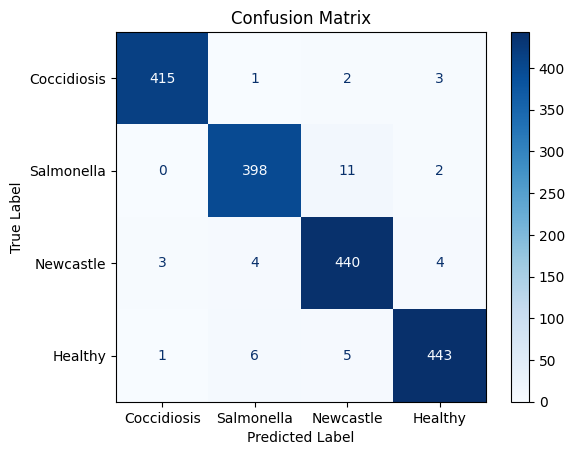


Classification Report:
              precision    recall  f1-score   support

 Coccidiosis       0.99      0.99      0.99       421
  Salmonella       0.97      0.97      0.97       411
   Newcastle       0.96      0.98      0.97       451
     Healthy       0.98      0.97      0.98       455

    accuracy                           0.98      1738
   macro avg       0.98      0.98      0.98      1738
weighted avg       0.98      0.98      0.98      1738



In [39]:
get_metric(model=cnn1_model,
           X=X_valid_224,
           name_model="TriConvLayer Model",
           y_actual=y_valid_224,
           figsize=(12, 10))

In [55]:
# check model summary
# Total params: 2,263,108 parameters (equal params between transfer learning and fine tuning )
# Get file size in bytes for a given model
print(f"Size of TriConvLayer model(MB): {(os.stat(cnn1_path).st_size/1_048_576)}") # convert Bytes to MB
print(f"Size of FiveConvLayer model(MB): {(os.stat(cnn2_path).st_size/1_048_576)}")

Size of TriConvLayer model(MB): 4.8196563720703125
Size of FiveConvLayer model(MB): 0.6652297973632812
